<a href="https://colab.research.google.com/github/shyDaniel/Binary_Classification/blob/master/Logistic_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **BINARY CLASSIFICATION - PREDICTING WHETHER A PERSON'S SALARY WILL BE HIGHER THAN $ 50,000, INCLUDING TWO DIFFERENT APPROACHES: DISCRIMINATIVE MODEL - LOGISTIC REGRESSION, AND GENERATING MODEL - NAIVE BAYES**

# **This notebook contains the logistic regression model.**

Kaggle: https://www.kaggle.com/c/ml2020spring-hw2/overview

Hanyu Song 03/23/2020

In [1]:
import pandas as pd
import numpy as np 

!gdown --id '1JuYMZyt0-jwVIwiVs-mgQE8i_O3QUyT3' --output Xtrain.zip
!gdown --id '1iVZaPjgTmwwp683hV8cw-7Q2r3AunasO' --output Xtest.zip
!gdown --id '1C0eGiL5azG49lnS45LxCdbrY0Ce4nNU2'
!unzip Xtrain.zip
!unzip Xtest.zip

Downloading...
From: https://drive.google.com/uc?id=1JuYMZyt0-jwVIwiVs-mgQE8i_O3QUyT3
To: /content/Xtrain.zip
2.79MB [00:00, 88.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iVZaPjgTmwwp683hV8cw-7Q2r3AunasO
To: /content/Xtest.zip
100% 1.42M/1.42M [00:00<00:00, 93.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C0eGiL5azG49lnS45LxCdbrY0Ce4nNU2
To: /content/Y_train
100% 423k/423k [00:00<00:00, 58.6MB/s]
Archive:  Xtrain.zip
  inflating: X_train                 
Archive:  Xtest.zip
  inflating: X_test                  


## **LOGISTIC REGRESSION**

**CONVERTING DATASETS INTO NUMPY MATRICES**

In [0]:
np.random.seed(0)
X_train_fpath = '/content/X_train'
Y_train_fpath = '/content/Y_train'
X_test_fpath = '/content/X_test'
output_fpath = '/output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

**NORMALIZATION**

In [3]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


**Some useful functions in Logistic Regression**

In [0]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.dot(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

**CROSS-ENTROPY**

In [0]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1) # ELEMENT-WISE PRODUCTION
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

**TRAINING**

In [54]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 50
batch_size = 8
learning_rate = 0.05

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Use adagrad to optimize learning rate
adagradw = np.zeros((data_dim,))
adagradb = 0
eps = 0.0000000001

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        
        adagradw += w_grad ** 2
        adagradb += b_grad ** 2

        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(adagradw + eps) * w_grad
        b = b - learning_rate/np.sqrt(adagradb + eps) * b_grad

            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.2737360233266404
Development loss: 0.2939921198473981
Training accuracy: 0.8852754454228957
Development accuracy: 0.8772576483597494


In [62]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 1000
learning_rate = 1

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Use adagrad to optimize learning rate
adagradw = np.zeros((data_dim,))
adagradb = 0
eps = 0.0000000001

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    X = X_train
    Y = Y_train

        # Compute the gradient
    w_grad, b_grad = _gradient(X, Y, w, b)
        
    adagradw += w_grad ** 2
    adagradb += b_grad ** 2

        # gradient descent update
        # learning rate decay with time
    w = w - learning_rate/np.sqrt(adagradw + eps) * w_grad
    b = b - learning_rate/np.sqrt(adagradb + eps) * b_grad

            
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    curloss = _cross_entropy_loss(y_train_pred, Y_train) / train_size

    if (epoch % 100 == 0):
      print ("In the ",epoch," th iteration, the loss is: ", curloss)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(curloss)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

In the  0  th iteration, the loss is:  5.640612352487127
In the  100  th iteration, the loss is:  0.3658910358408261
In the  200  th iteration, the loss is:  0.3213275246090302
In the  300  th iteration, the loss is:  0.2959598198196976
In the  400  th iteration, the loss is:  0.2851108377467621
In the  500  th iteration, the loss is:  0.275907399324037
In the  600  th iteration, the loss is:  0.2720910981554639
In the  700  th iteration, the loss is:  0.2684718872802823
In the  800  th iteration, the loss is:  0.26749078355455524
In the  900  th iteration, the loss is:  0.26686323048524224
Training loss: 0.265771404397878
Development loss: 0.265771404397878
Training accuracy: 0.885398320704485
Development accuracy: 0.8761518614080354


**PLOT LOSS CURVE**

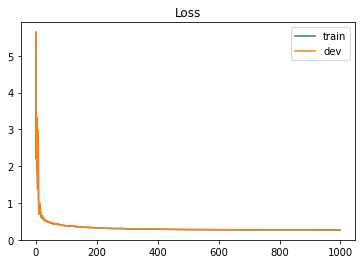

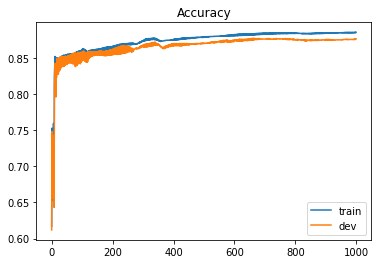

In [64]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

np.save('model_weights.npy', w)
np.save('constant.npy', b)

## **Predicting**

In [0]:
# Predict testing labels
weights = np.load('model_weights.npy')
cons = np.load('constant.npy')
predictions = _predict(X_test, weights, cons)

## **Save result to a csv file**

In [0]:
df = pd.DataFrame(np.empty((predictions.shape[0], 2)), index = np.arange(predictions.shape[0]) + 1, columns = ['id', 'label'], dtype = int)
for i in range (predictions.shape[0]):
  df.iloc[i, 0] = i
  df.iloc[i, 1] = predictions[i]
df.to_csv('submission.csv', index = False)